# Tree based methods

In [11]:
import os

dir = str(os.getcwd())
split_dir = dir.split('\\')

# Set the github repository directory
for folder in reversed(split_dir):
    if folder != 'AA_Project_G6' and 'AA_Project_G6' in split_dir:
        os.chdir(os.path.dirname(os.getcwd()))
    else:
        break

print('Current directory:', os.getcwd())

Current directory: c:\Users\AndreLopes\Desktop\git\AA_Project_G6


In [12]:
import pandas as pd
import numpy as np

# Import data from .csv file
df = pd.read_csv(filepath_or_buffer='./data/processed/data_processed.csv', delimiter=',')

In [13]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, roc_curve, accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8]

In [14]:
#Dataset division: the output y (Attrition_Flag_Existing Customer) and the input X (all variables except Attrition_Flag_Existing Customer)
X = df.drop(['Attrition_Flag_Existing Customer'], axis=1)
y = df['Attrition_Flag_Existing Customer']

#Divide the data into train and test with a train size of 70%
seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = seed)

### Classification Trees

In [15]:
#Define function for fitting the model and printing the performance indicators and confusion matrices for various depths
def classificationtree(depth):
    #Model fit
    clf_dt = DecisionTreeClassifier(max_depth=depth)
    clf_dt.fit(X_train, y_train)

    #Print Performance indicators
    print("Performance indicators:")
    y_pred = clf_dt.predict(X_test)
    print("Accuracy: {:.2f}%\n".format(accuracy_score(y_test, y_pred)*100))

    #Print confusion matrix
    print("Confusion matrix:\n")
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred).T, index=['Predicted attrited customers', 'Preticted existing costumers'], columns=['Actual Attrited', 'Actual Existing '])
    print(cm)
    
    return clf_dt

In [16]:
#Define function for graphic representation of the tree for various depths
def treegraph(depth):
    export_graphviz(clf_dt, 
                    out_file = "./code/results/existing_costumer_tree_depth" + str(depth) + ".dot", 
                    feature_names = X_train.columns)

    with open("existing_costumer_tree_depth" + str(depth) + ".dot") as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)

In [17]:
#Define function for ploting the feature importance attribute of the Classification Tree
def importanceplot():
    importance = pd.DataFrame({'Importance':clf_dt.feature_importances_*100}, 
                                  index = X.columns)

    return importance.sort_values(by = 'Importance', 
                               axis = 0, 
                               ascending = True).plot(kind = 'barh', 
                                                      color = 'red', )

    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None

Depth = 2

Performance indicators:
Accuracy: 89.04%

Confusion matrix:

                              Actual Attrited  Actual Existing 
Predicted attrited customers              223               100
Preticted existing costumers              233              2483


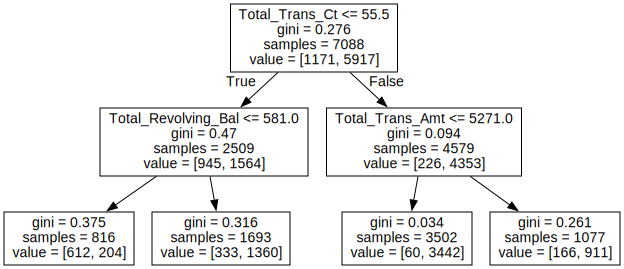

In [18]:
clf_dt = classificationtree(2)
treegraph(2)

<AxesSubplot:>

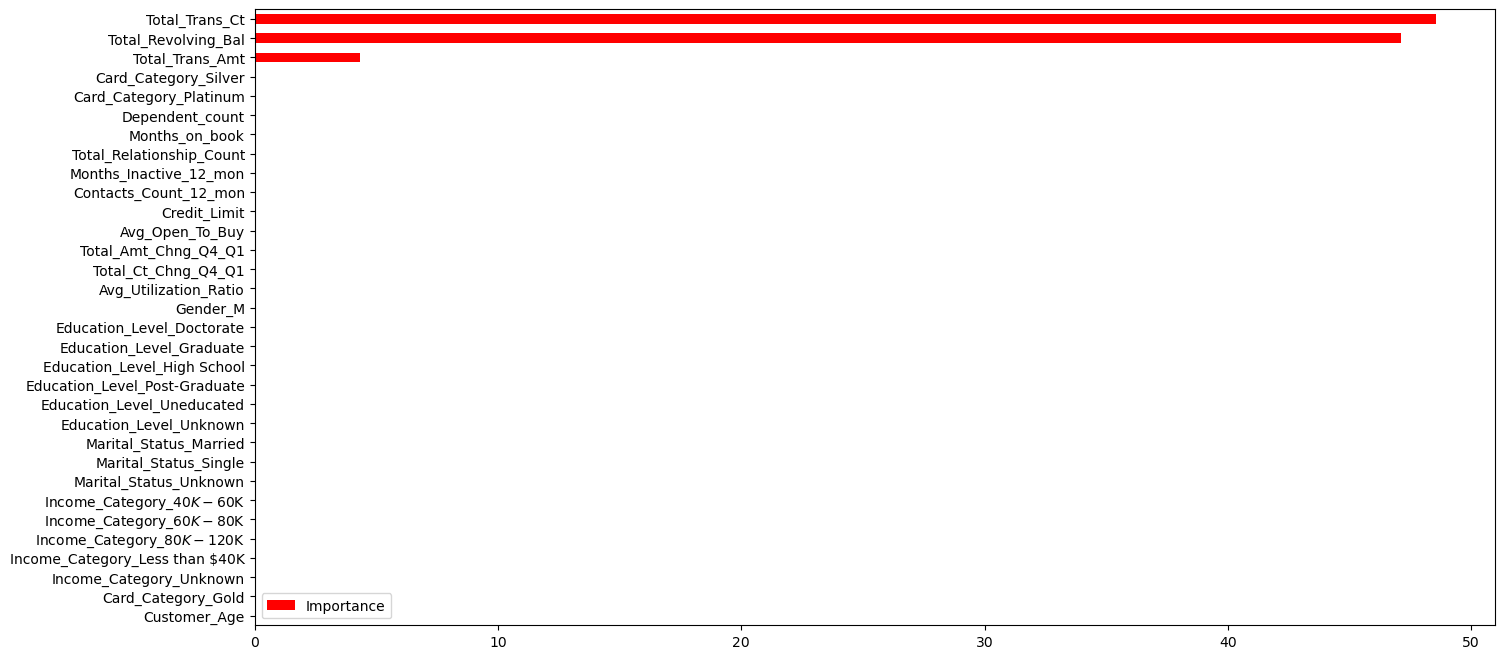

In [19]:
importanceplot()

Depth = 4

Performance indicators:
Accuracy: 91.81%

Confusion matrix:

                              Actual Attrited  Actual Existing 
Predicted attrited customers              284                77
Preticted existing costumers              172              2506


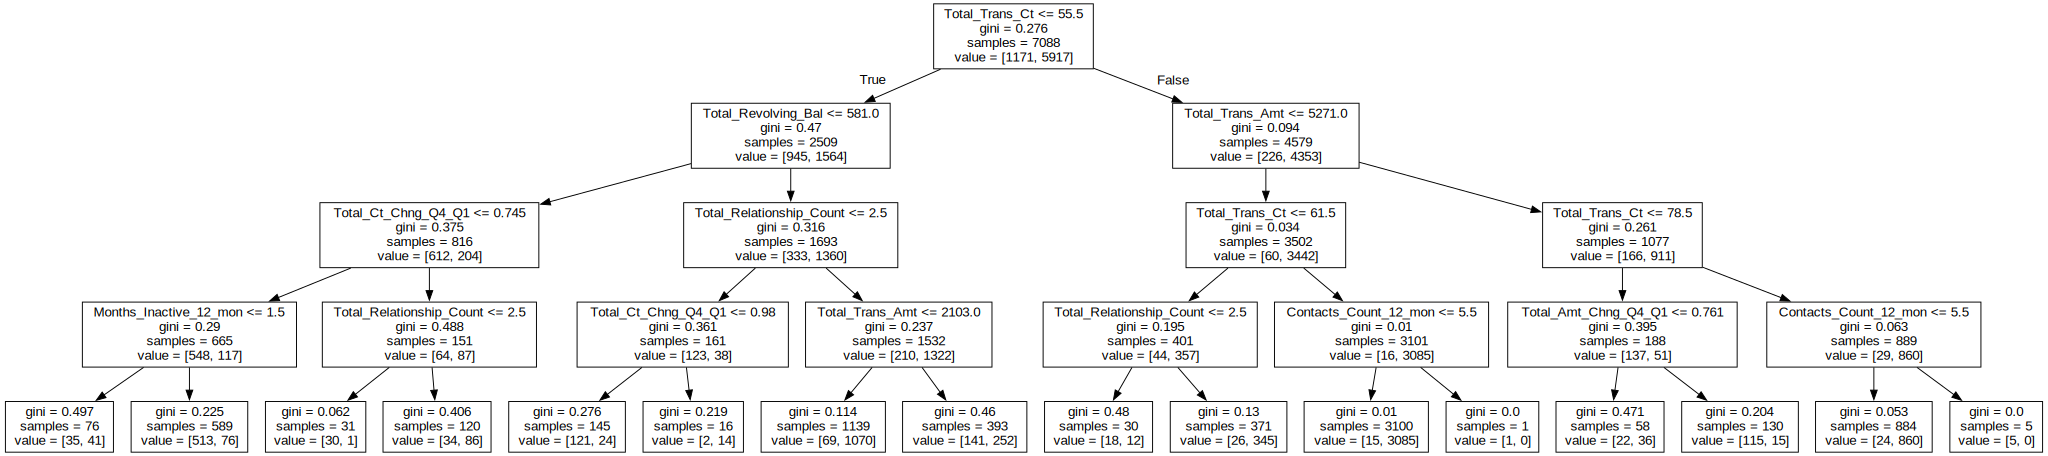

In [20]:
clf_dt = classificationtree(4)
treegraph(4)

<AxesSubplot:>

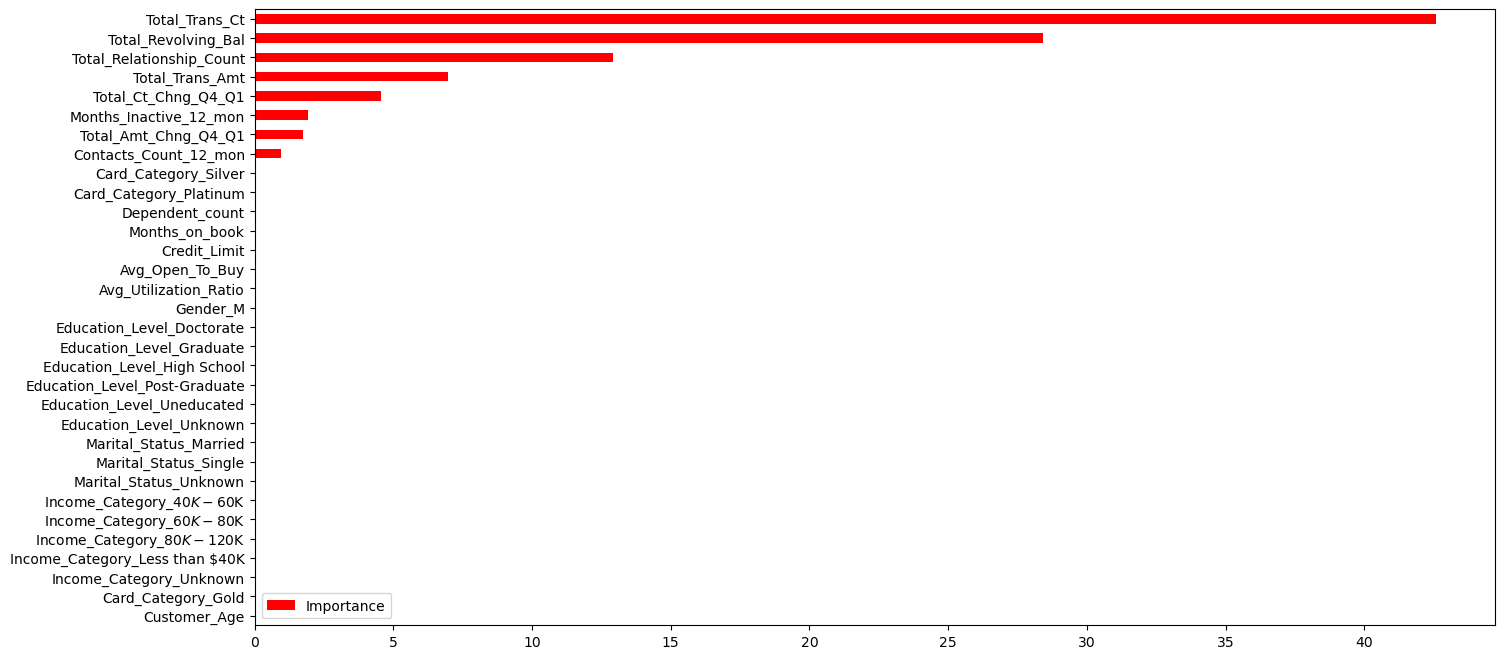

In [21]:
importanceplot()

Depth = 6

Performance indicators:
Accuracy: 94.14%

Confusion matrix:

                              Actual Attrited  Actual Existing 
Predicted attrited customers              355                77
Preticted existing costumers              101              2506


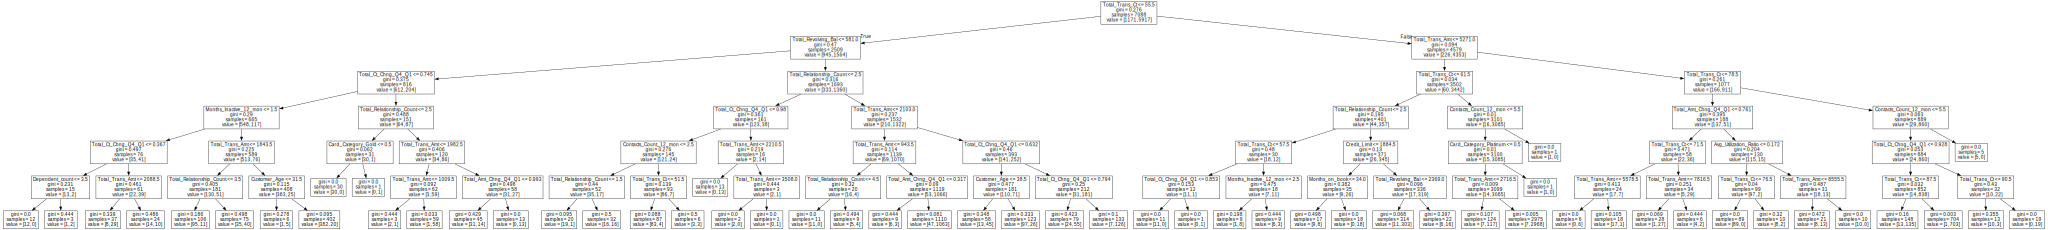

In [22]:
clf_dt = classificationtree(6)
treegraph(6)

<AxesSubplot:>

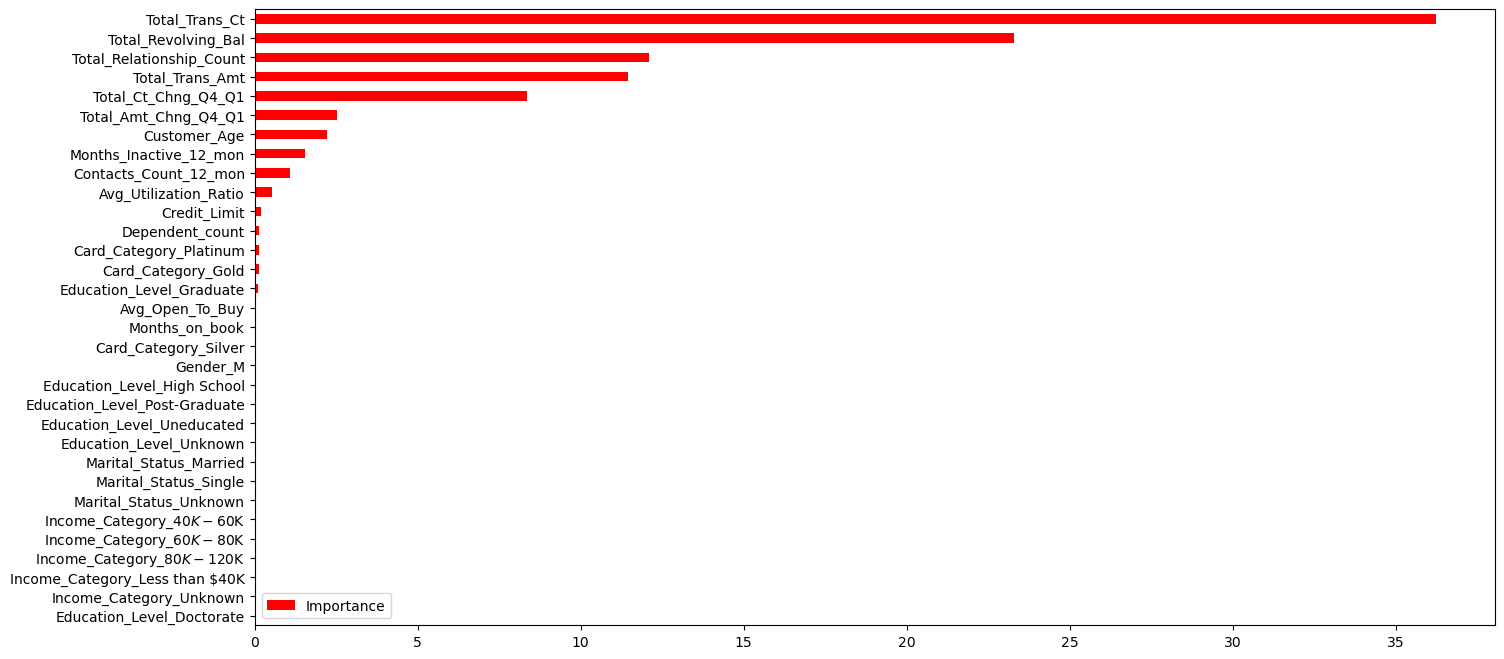

In [23]:
importanceplot()

## Random forest Classifier

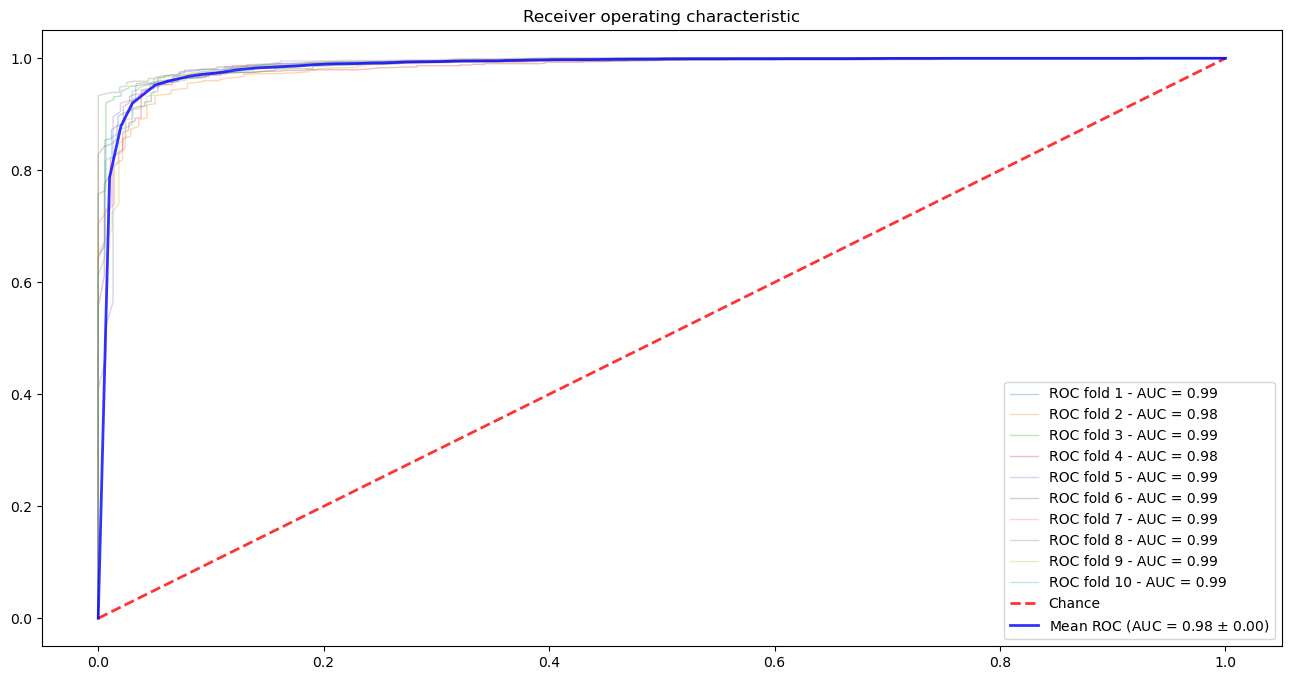

In [24]:
# KFold cross validation with 10 folds
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Random Forest Classifier
clf_rfc = RandomForestClassifier(n_estimators=200, random_state=seed)


tprs = []
aucs = []

mean_fpr = np.linspace(0,1,100)

fig, ax = plt.subplots()

for i, (train,test) in enumerate(kfold.split(X,y)):
    clf_rfc.fit(X.loc[train], y[train])
    y_proba = clf_rfc.predict_proba(X.loc[test]) 
    fpr, tpr, _ = roc_curve(y[test], y_proba[:,1])
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(auc(fpr,tpr))
    
    ax.plot(
        fpr, tpr,
        label='ROC fold ' + str(i+1) +  ' - AUC = ' + str(np.round(auc(fpr,tpr),2)),
        lw=1,
        alpha=0.3)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean roc curve auc
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic",
)

ax.legend(loc="lower right")
plt.show()


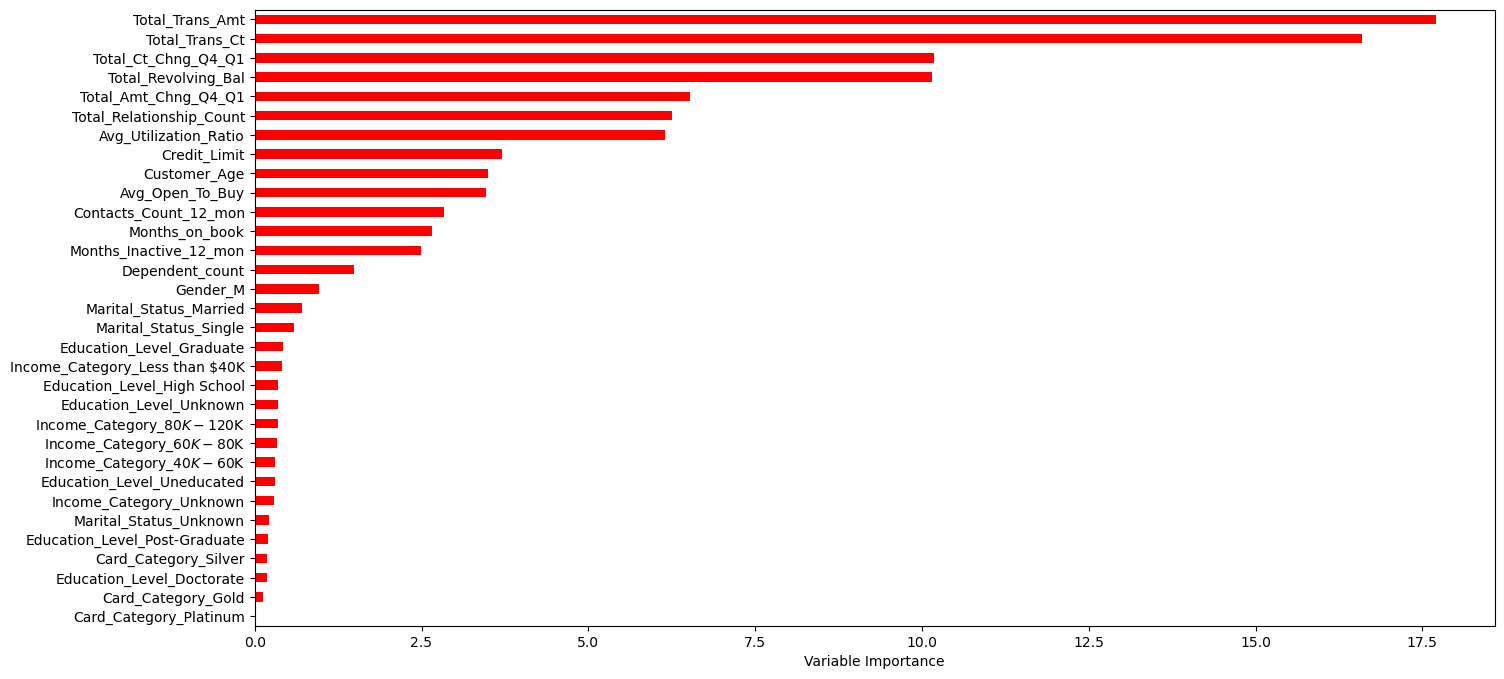

In [25]:
#Plot the feature importance attribute of the Random Forest Classifier
importance = pd.DataFrame({'Importance':clf_rfc.feature_importances_*100}, 
                          index = X.columns)

importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'red', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### XGBoost classifier

In [26]:
#XGBoost classifier fit
xgb_clf = XGBClassifier() 
xgb_clf.fit(X_train, y_train)

#Print Performance indicators
print("Performance indicators:")
y_pred = xgb_clf.predict(X_test)
print("Accuracy: {:.2f}%\n".format(accuracy_score(y_test, y_pred)*100))

#Print confusion matrix
print("Confusion matrix:\n")
cm = pd.DataFrame(confusion_matrix(y_test, y_pred).T, index=['Predicted attrited customers', 'Preticted existing costumers'], columns=['Actual Attrited', 'Actual Existing '])
print(cm)

Performance indicators:
Accuracy: 97.30%

Confusion matrix:

                              Actual Attrited  Actual Existing 
Predicted attrited customers              401                27
Preticted existing costumers               55              2556


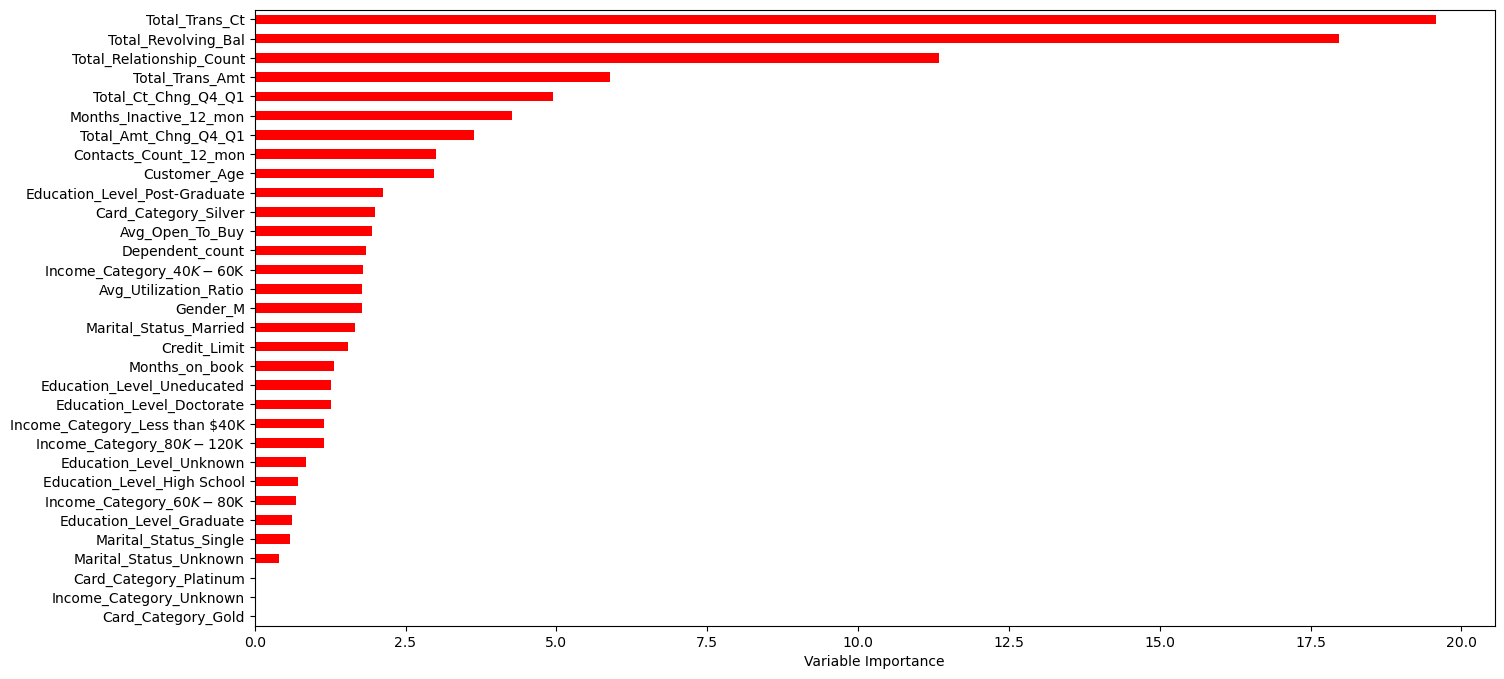

In [27]:
#Plot the feauture importance of XGBoost classifier fit
feature_importance = xgb_clf.feature_importances_*100

rel_imp = pd.Series(feature_importance, index = X.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None